In [2]:
from galactic import GalacticDataset

None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


## Loading Data

Galactic can load datasets from typical file formats (CSV, JSONL, Parquet), as well as from HuggingFace. If you're loading a massive dataset from HuggingFace, you can even filter data as it streams in, ensuring you don't load any duplicates, and you only hang on to data you want. For instance, here we will load the Falcon RefinedWeb dataset, but automatically deduplicate it, and only keep examples with fewer than 1024 characters. Let's get 5000 samples that meet our requirements.

In [3]:
filter_func = lambda x: len(x['content']) < 1024
dataset = GalacticDataset.from_hugging_face_stream(
    "tiiuae/falcon-refinedweb",
    split="train",
    filters=[filter_func],
    dedup_fields=["content"],
    max_samples=5000
)

Resolving data files:   0%|          | 0/5534 [00:00<?, ?it/s]

Loading samples from tiiuae/falcon-refinedweb:   0%|          | 0/5000 [00:00<?, ?it/s]

INFO: Loaded 5000 samples from tiiuae/falcon-refinedweb. 


Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

## Understanding the Data
Galactic is designed to help you understand unstructured text datasets. Let's start with some basics: we'll get the lengths of the texts using our tokenizer of choice, detect the language of the text, and scan for PII.

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

INFO: Counted tokens in fields: ['content'], added metadata to __token_count__


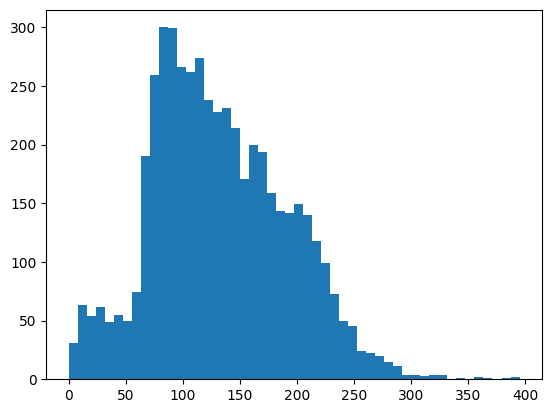

In [4]:
import matplotlib.pyplot as plt
dataset = dataset.count_tokens(fields=["content"], tokenizer="gpt2")
plt.hist(dataset["__token_count__content"], bins=50);

In [5]:
from collections import Counter
dataset.detect_language(field="content")
Counter(dataset["__language"])

Parameter 'function'=<function detect_language.<locals>.detect_ at 0x137578f70> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

INFO: Detected language in field content, added language metadata to '__language'.


Counter({'en': 4975,
         'es': 7,
         'fr': 7,
         'de': 3,
         'da': 2,
         'ru': 1,
         'nl': 1,
         'pt': 1,
         'sh': 1,
         'eo': 1,
         'ceb': 1})

In [6]:
dataset.detect_pii(
    fields=["content"]
)
print("Email:", sum(dataset["__pii__email"]))
print("Phone:", sum(dataset["__pii__phone"]))
print("Username/Password:", sum(dataset["__pii__credential"]))

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

INFO: Detected PII in fields: ['content']; added __pii__email, __pii__phone, __pii__credential, and __pii__any metadata.


Email: 285
Phone: 242
Username/Password: 9


## Custom Tagging & Filtering
The built-in functions are just to get you started--Galactic allows you to tag and filter your data however you want. For instance, here we'll do the following:
* Filter out all examples that have "blogspot" in the URL.
* Tag all examples that mention fruit or vegetables.

In [7]:
dataset = dataset.filter_string(
    fields=["url"],
    values=["blogspot"]
)
len(dataset)

Filter:   0%|          | 0/5000 [00:00<?, ? examples/s]

INFO: Filtered dataset in-place with exact string matching on fields: ['url']


4902

In [8]:
dataset = dataset.tag_regex(
    fields=["content"],
    regex="fruit|Fruit|vegetable|Vegetable|veggie|Veggie",
    tag="fruit_veggie"
)
f'{sum(dataset["__tag__fruit_veggie"])} records tagged with __tag__fruit_veggie'


Map:   0%|          | 0/4902 [00:00<?, ? examples/s]

INFO: Tagged dataset in-place with tag '__tag__fruit_veggie', using regex matching on fields: ['content']


'38 records tagged with __tag__fruit_veggie'

## Embeddings & Clustering

Text embeddings are a great way to explore and understand unstructured data. Galactic can compute embeddings right on your CPU with the `gte-small` model, and then use them to cluster and deduplicate your data. (You also have the option to use OpenAI API embeddings as the backend--they're faster, but each embedding is larger, and you have to provide an API key.) On my Intel Macbook (no fancy M1 or M2), I can compute 1000 embeddings in a couple minutes. Longer texts also take longer since they have to be chunked into 512-token segments.

In [9]:
# to use openai, set dataset.openai_api_key = [...], and use backend="openai"
dataset.get_embeddings(field="content", backend="cpu")

Map:   0%|          | 0/4902 [00:00<?, ? examples/s]

INFO: Created embeddings on field 'content'


                                             content  \
0  these birches can be found in many places in E...   
1  Pesky?\nthis was a high school project for a p...   
2  metalkingdom.net [ 80′s @ 8 Feature Video – Bi...   
3  Splice Review\nBlack Ops Escalation Map Pack [...   
4  Billy Gibbons & Co., ‘Oh Well’ – Song Review\n...   
5  Stay Curious Alpro\nWe created the 'interactiv...   
6  I got off the plane, grabbed my bags, I saw sh...   
7  Call for Speakers!\nThis is it! Finally we’re ...   
8                           Posts Tagged frequency »   
9  Get a trade-in offer for your vehicle.\nREADY ...   

                                                 url           timestamp  \
0  http://100parts.wordpress.com/2012/08/04/astra... 2013-05-18 10:42:00   
1  http://101squadron.com/blog/2007/05/pesky-pecu... 2013-05-18 10:21:35   
2             http://1037theloon.com/tags/scorpions/ 2013-05-18 10:21:51   
3    http://1063thebuzz.com/category/reviews/page/7/ 2013-05-18 10:31:09   
4  

Once we've computed embeddings for a dataset, we can cluster it with k-means. Clusters can help discover domains in the data, or subsets that we might want to remove. They can also be used downstream for intra-cluster semantic deduplication (i.e. removing examples that share a cluster and are very close by in the embedding space).

In [10]:
dataset.cluster(n_clusters=10)
dataset.get_cluster_info(field="content")

/Users/ben/.pyenv/versions/3.9.5/envs/docent/lib/python3.9/site-packages/threadpoolctl.py:1019: RuntimeWarning: libc not found. The ctypes module in Python 3.9 is maybe too old for this OS.
  warnings.warn(


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Map:   0%|          | 0/4902 [00:00<?, ? examples/s]

Cluster 0 (550 items)
	, advisers, activists, and policy makers can make their voices:
---
	QUICK LINKS
About
Meeting Schedule
Outreach & Other Coordination Efforts
Guidance Documents/Publications
Strategic Action Plans.
---
	How to Bring about Change - CIDSE discussion paper (Available in EN - FR)
The Busan High Level Forum on Aid Effectiveness (HLF4) resulted in a non-binding Global Partnership for Effective Development Cooperation (GP), endorsed by all the stakeholders involved, including emerging countries and civil society organizations (CSOs).
In the work-area ‘Rethinking Development’ we critically consider the wider framework in which policies to promote development and the fight against poverty are designed and implemented.
---
Cluster 1 (549 items)
	.
Wow!...the holiday season is already upon us, and I, as I'm sure most people do, give thought to their purchases and have many questions needing to...Read More ->
I've recently returned to my boyhood obsession...no, not Farrah's 

Semantic deduplication within clusters is carried out with `semdedup`. You can provide a target retention rate for what percent of data you want to keep (the threshold will be tuned to achieve roughly this rate), or you can provide a cosine similarity threshold, and pairs within a cluster whose similarity is above the threshold will be considered duplicates.

In [11]:
dataset.semdedup(target_retention=0.75)

INFO: Tuning threshold on 3 clusters...


Filter:   0%|          | 0/4902 [00:00<?, ? examples/s]

Threshold: 0.861, Retention: 0.011
Threshold: 0.931, Retention: 0.964
Threshold: 0.896, Retention: 0.073
Threshold: 0.913, Retention: 0.489
Threshold: 0.922, Retention: 0.827
Threshold: 0.917, Retention: 0.647
Threshold: 0.92, Retention: 0.739
Threshold: 0.921, Retention: 0.776
Threshold: 0.92, Retention: 0.759


Filter:   0%|          | 0/4902 [00:00<?, ? examples/s]

Threshold: 0.878, Retention: 0.009
Threshold: 0.939, Retention: 0.996
Threshold: 0.908, Retention: 0.321
Threshold: 0.924, Retention: 0.891
Threshold: 0.916, Retention: 0.625
Threshold: 0.92, Retention: 0.774
Threshold: 0.918, Retention: 0.709
Threshold: 0.919, Retention: 0.745


Filter:   0%|          | 0/4902 [00:00<?, ? examples/s]

Threshold: 0.884, Retention: 0.02
Threshold: 0.942, Retention: 0.993
Threshold: 0.913, Retention: 0.571
Threshold: 0.928, Retention: 0.933
Threshold: 0.92, Retention: 0.792
Threshold: 0.917, Retention: 0.687
Threshold: 0.919, Retention: 0.752


INFO: Threshold: 0.92


Filter:   0%|          | 0/4902 [00:00<?, ? examples/s]

INFO: Cluster 0 has 106 duplicates (19.3%).



Filter:   0%|          | 0/4902 [00:00<?, ? examples/s]

INFO: Cluster 1 has 133 duplicates (24.2%).



Filter:   0%|          | 0/4902 [00:00<?, ? examples/s]

INFO: Cluster 2 has 489 duplicates (72.7%).



Filter:   0%|          | 0/4902 [00:00<?, ? examples/s]

INFO: Cluster 3 has 125 duplicates (26.7%).



Filter:   0%|          | 0/4902 [00:00<?, ? examples/s]

INFO: Cluster 4 has 96 duplicates (23.8%).



Filter:   0%|          | 0/4902 [00:00<?, ? examples/s]

INFO: Cluster 5 has 354 duplicates (59.8%).



Filter:   0%|          | 0/4902 [00:00<?, ? examples/s]

INFO: Cluster 6 has 80 duplicates (27.6%).



Filter:   0%|          | 0/4902 [00:00<?, ? examples/s]

INFO: Cluster 7 has 96 duplicates (15.6%).



Filter:   0%|          | 0/4902 [00:00<?, ? examples/s]

INFO: Cluster 8 has 174 duplicates (37.7%).



Filter:   0%|          | 0/4902 [00:00<?, ? examples/s]

INFO: Cluster 9 has 25 duplicates (8.3%).



Filter:   0%|          | 0/4902 [00:00<?, ? examples/s]

INFO: Removed 1678 / 4902 items flagged as semantic near-duplicates (34.23%).


                                             content  \
0  these birches can be found in many places in E...   
1  Pesky?\nthis was a high school project for a p...   
2  metalkingdom.net [ 80′s @ 8 Feature Video – Bi...   
3  Billy Gibbons & Co., ‘Oh Well’ – Song Review\n...   
4  Stay Curious Alpro\nWe created the 'interactiv...   
5  I got off the plane, grabbed my bags, I saw sh...   
6  Call for Speakers!\nThis is it! Finally we’re ...   
7                           Posts Tagged frequency »   
8  Get a trade-in offer for your vehicle.\nREADY ...   
9  Professional/Career: Student\nBasic Interests:...   

                                                 url           timestamp  \
0  http://100parts.wordpress.com/2012/08/04/astra... 2013-05-18 10:42:00   
1  http://101squadron.com/blog/2007/05/pesky-pecu... 2013-05-18 10:21:35   
2             http://1037theloon.com/tags/scorpions/ 2013-05-18 10:21:51   
3  http://1069therock.com/billy-gibbons-co-oh-wel... 2013-05-18 10:32:50   
4  

## Saving the result

Finally, let's save this data--either for more Galactic goodness later on (who wants to compute those embeddings again?), or so we can use it downstream for retrieval or fine-tuning.

In [14]:
dataset.calc_perplexity("input")

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

[2023-09-15 17:09:41.585] [ctranslate2] [thread 6659588] [warning] The compute type inferred from the saved model is int8_float16, but the target device or backend do not support efficient int8_float16 computation. The model weights have been automatically converted to use the int8_float32 compute type instead.


Map:   0%|          | 0/3224 [00:00<?, ? examples/s]

INFO: Calculated perplexity-per-byte in field input, added perplexity metadata to '__perplexity'.


                                             content  \
0  these birches can be found in many places in E...   
1  Pesky?\nthis was a high school project for a p...   
2  metalkingdom.net [ 80′s @ 8 Feature Video – Bi...   
3  Billy Gibbons & Co., ‘Oh Well’ – Song Review\n...   
4  Stay Curious Alpro\nWe created the 'interactiv...   
5  I got off the plane, grabbed my bags, I saw sh...   
6  Call for Speakers!\nThis is it! Finally we’re ...   
7                           Posts Tagged frequency »   
8  Get a trade-in offer for your vehicle.\nREADY ...   
9  Professional/Career: Student\nBasic Interests:...   

                                                 url           timestamp  \
0  http://100parts.wordpress.com/2012/08/04/astra... 2013-05-18 10:42:00   
1  http://101squadron.com/blog/2007/05/pesky-pecu... 2013-05-18 10:21:35   
2             http://1037theloon.com/tags/scorpions/ 2013-05-18 10:21:51   
3  http://1069therock.com/billy-gibbons-co-oh-wel... 2013-05-18 10:32:50   
4  

In [15]:
dataset

                                             content  \
0  these birches can be found in many places in E...   
1  Pesky?\nthis was a high school project for a p...   
2  metalkingdom.net [ 80′s @ 8 Feature Video – Bi...   
3  Billy Gibbons & Co., ‘Oh Well’ – Song Review\n...   
4  Stay Curious Alpro\nWe created the 'interactiv...   
5  I got off the plane, grabbed my bags, I saw sh...   
6  Call for Speakers!\nThis is it! Finally we’re ...   
7                           Posts Tagged frequency »   
8  Get a trade-in offer for your vehicle.\nREADY ...   
9  Professional/Career: Student\nBasic Interests:...   

                                                 url           timestamp  \
0  http://100parts.wordpress.com/2012/08/04/astra... 2013-05-18 10:42:00   
1  http://101squadron.com/blog/2007/05/pesky-pecu... 2013-05-18 10:21:35   
2             http://1037theloon.com/tags/scorpions/ 2013-05-18 10:21:51   
3  http://1069therock.com/billy-gibbons-co-oh-wel... 2013-05-18 10:32:50   
4  

In [17]:
ex = dataset.filter(lambda x: x["__cluster"] == 4)
type(ex)

Filter:   0%|          | 0/3224 [00:00<?, ? examples/s]

galactic.galactic.GalacticDataset